# LIBRARIES

In [1]:
import pickle
from Environment import *
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from step3_ucb1 import *
from step4_ucb1 import *
from step5_ucb1 import *
from Step3_TS import *
from Step4_TS import *
from Step5_TS import *

# ENVIRONMENT DEFINITION 

- Environment fixed informations and Products definition

In [2]:
np.random.seed(1)

products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]
# Dictionary fixing the secondary products linked to 
secondary_dict= {        
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}

# Matrix n_prod*n_prices collecting the possible prices for each product. Prices are in ascending order
prices = [[8., 9, 10, 11],
          [10., 11, 12, 13],
          [20., 21, 23, 25],
          [28., 30, 31, 33],
          [40., 42, 43, 45]]
# Production cost of the products
cost = [5, 7.8, 18.1, 23.5, 32]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente
# Computation of margins linked to each product for a particular choice of price
cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2
# Creation of the 5 objects of Product class
for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# Parameter for the computation of the click probability on the SECOND secondary product
lambda_q = 0.7

- User Category 1: Young and Inexpert

In [3]:
# Parameters for the distribution describing the reservation price
res_price_params_1 = {
    "mean": [9, 15, 22, 33, 35],
    "std": [1, 2, 1, 1.5, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_1 = [[0, 0.7, 0.3, 0, 0],
                 [0.6, 0, 0.5, 0, 0],
                 [0, 0.7, 0, 0.3, 0],
                 [0, 0, 0.4, 0, 0.1],
                 [0.5, 0, 0.3, 0, 0]]
prob_lambda_1 = lambda_correct(np.matrix(probabilities_1), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_1 = [15, 15, 10, 5, 5]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_1 = [2, 1, .5, .2, .1]

user1 = UserCat(alphas_1, res_price_params_1, poisson_lambda_1, prob_lambda_1, 'Young and Not Expert')

- User Category 2: Old and Inexpert

In [4]:
# Parameters for the distribution describing the reservation price
res_price_params_2 = {
    "mean": [9, 16, 25, 41, 47],
    "std": [1, 2.5, 1.5, 3, 2]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_2 = [[0, 0.5, 0.4, 0, 0],
                 [0.4, 0, 0.6, 0, 0],
                 [0, 0.7, 0, 0.5, 0],
                 [0, 0, 0.5, 0, 0.3],
                 [0, 0, 0.5, 0.3, 0]]
prob_lambda_2 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_2 = [7, 12, 12, 12, 7]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_2 = [0.5, 1, 2, 1, 0.5]

user2 = UserCat(alphas_2, res_price_params_2, poisson_lambda_2, prob_lambda_2, 'Old and Not Expert')

- User Category 3: Expert

In [5]:
# Parameters for the distribution describing the reservation price
res_price_params_3 = {
    "mean": [8, 13, 24, 39, 50],
    "std": [1, 1.5, 2, 2, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_3 = [[0, 0, 0.6, 0.4, 0],
                 [0, 0, 0, 0.7, 0.4],
                 [0, 0.4, 0, 0.6, 0],
                 [0, 0, 0.3, 0, 0.7],
                 [0, 0, 0.4, 0.6, 0]]
prob_lambda_3 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_3 = [5, 5, 10, 15, 15]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_3 = [0.1, 0.2, 0.5, 1.5, 1.5]

user3 = UserCat(alphas_3, res_price_params_3, poisson_lambda_3, prob_lambda_3, 'Expert')

- User Category 0: Aggregated demand

In [6]:
# Parameters for the distribution describing the reservation price
res_price_params_0 = {
    "mean": [9.7, 12.7, 24.5, 31.6, 41.1],
    "std": [1.5, 2, 4, 2.5, 3]
}

# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_0 = [[0, 0.6, 0.2, 0, 0],
                 [0.5, 0, 0.4, 0, 0],
                 [0, 0.5, 0, 0.5, 0],
                 [0, 0, 0.6, 0, 0.5],
                 [0, 0, 0.3, 0.5, 0]]
prob_lambda_0 = lambda_correct(np.matrix(probabilities_0), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_0 = [10, 10, 10, 10, 10]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_0 = [1.5, 1, .5, .5, .2]

user0 = UserCat(alphas_0, res_price_params_0, poisson_lambda_0, prob_lambda_0)

- Environment creation

In [7]:
# COMMON
# probability distribution of the features
# the following list has to be interpreted in the following way:
# values_i is the parameter of the bernoulli for feature i; in our case feature0 is 1(0) for Old/Young
# while feature1 is 1(0) for Expert(Not Expert)
feature_prob = [0.3, 0.4]
# CASE WITH 3 USERS :
# list of users 
users3 = [user1, user2, user3]
feature_matrix3 = np.array([[0, 1], [2, 2]]) # values represent the label of the User Category
env3 = Environment(users3, products, secondary_dict, feature_matrix3, feature_prob)

# CASE WITH AGGREGATED USER :
users0 = [user0]
feature_matrix0 = np.array([[0, 0], [0, 0]])
env = Environment(users0, products, secondary_dict, feature_matrix0, feature_prob)

In [8]:
opt_rewards_array, opt_comb_list = env3.optimal_reward(Disaggregated=True)
aggr_opt_reward, aggr_opt_comb = env3.optimal_reward()
dis_opt_reward = np.sum(np.array(env3.user_cat_prob)*opt_rewards_array)
print('Aggregated Optimal Reward : %.3f VS Disaggregated Optimal Reward : %.3f' %(aggr_opt_reward, dis_opt_reward))
print('Aggregated Optimal Price combination : %s' %aggr_opt_comb)
print('Optimal price combinations with users divided by category:')
for i, user in enumerate(env3.users):
    print('User\'s Category : %s - %s' %(user.category, str(opt_comb_list[i])))

Aggregated Optimal Reward : 19.876 VS Disaggregated Optimal Reward : 21.003
Aggregated Optimal Price combination : [0, 3, 1, 3, 3]
Optimal price combinations with users divided by category:
User's Category : Young and Not Expert - [0, 3, 0, 2, 0]
User's Category : Old and Not Expert - [0, 3, 2, 3, 2]
User's Category : Expert - [0, 1, 1, 3, 3]


In [11]:
# FUNZIONAMENTO EXPECTED REWARD PER STEP 7 
unique_partition = env3.expected_reward(price_combination=[2,3,2,1,0], group_list=[[0,0],[1,1],[0,1],[1,0]])
base_case = env3.expected_reward(price_combination=[2,3,2,1,0])
print('Unique Partition : %.6f  is equal to base case : %.6f' %(unique_partition, base_case))

Unique Partition : 13.627316  is equal to base case : 13.627316


In [82]:
np.matrix(env.theoretical_values['conversion_rates'][0])

matrix([[0.87146285, 0.67963081, 0.42074029, 0.19306234],
        [0.91149201, 0.80233746, 0.63683065, 0.44038231],
        [0.86970548, 0.80921305, 0.64616977, 0.45026178],
        [0.9250663 , 0.7389137 , 0.59483487, 0.28773972],
        [0.64306616, 0.38208858, 0.263258  , 0.09680048]])

In [83]:
np.random.seed(0)
d = env3.simulate_day_context(200, [[0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0]], np.array([[0,1],[2,2]]), 
["conversion_rates", "alpha_ratios", "products_sold"])

In [84]:
np.random.seed(0)
a = env3.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"], aggregated= False)
a

[{'CR_data': array([[457., 580., 458., 122.,   0.],
         [570., 582., 465., 122.,  60.]]),
  'initial_prod': array([333., 220., 228.,  38.,  53.]),
  'n_prod_sold': array([[1319., 1135.,  676.,  140.,    0.],
         [ 457.,  580.,  458.,  122.,    0.]]),
  'graph_weights': array([[0.        , 0.7063197 , 0.24038461, 0.        , 0.        ],
         [0.62698413, 0.        , 0.38541667, 0.        , 0.        ],
         [0.        , 0.6745098 , 0.        , 0.18918919, 0.        ],
         [0.        , 0.        , 0.36842104, 0.        , 0.05737705],
         [0.        , 0.        , 0.        , 0.        , 0.        ]]),
  'visualizations': array([[  0., 269., 312.,   0.,   0.],
         [378.,   0., 384.,   0.,   0.],
         [  0., 255.,   0., 444.,   0.],
         [  0.,   0.,  38.,   0., 122.],
         [  0.,   0.,   0.,   0.,   0.]]),
  'clicks': array([[  0., 190.,  75.,   0.,   0.],
         [237.,   0., 148.,   0.,   0.],
         [  0., 172.,   0.,  84.,   0.],
       

- Reservation Price Distribution Plot for one user

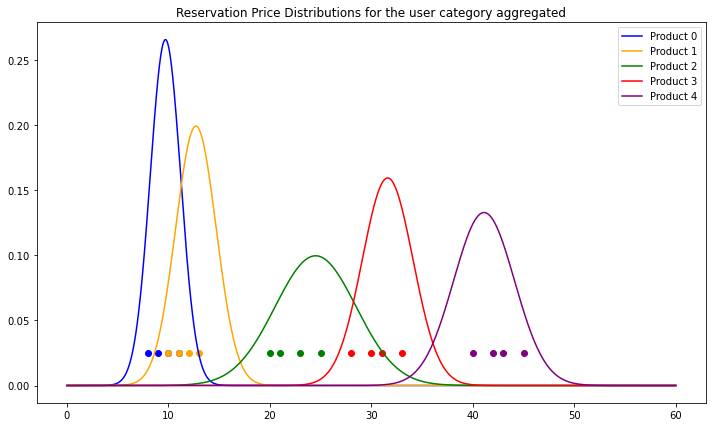

In [85]:
user_index = 0
x = np.arange(0, 60 , .01)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    res_price_distr = env.users[user_index].res_price_distr[i]
    y = res_price_distr.pdf(x)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])

for i in range(5):
    for j in range(4):
        plt.scatter(prices[i][j], 0.025, color = color_list[i])

plt.title("Reservation Price Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

* Number of Prouducts Sold Distributions Plot for a User

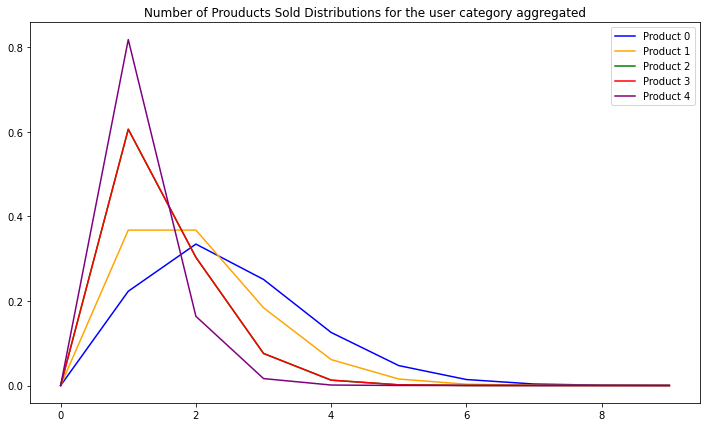

In [86]:
user_index = 0
x = np.arange(0, 10, 1)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    pois_l = env.users[user_index].poisson_lambda[i]
    distr = scipy.stats.poisson(pois_l)
    y = distr.pmf(x[:-1])
    y = np.insert(y, 0, 0)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])
    #plt.scatter(x, y, color = color_list[i], label = 'Product %d' %i)
    #plt.vlines(x, 0, y, color = color_list[i], lw=5, alpha=0.5)

plt.title("Number of Prouducts Sold Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

# Greedy Algorithm Example

In [87]:
greedy_optimizer = Greedy_optimizer(env)
greedy_optimizer.run()

{'expected_reward': 20.651157065146457, 'combination': [0, 1, 2, 1, 0]}

In [88]:
env.optimal_reward()

(20.651157065146457, [0, 1, 2, 1, 0])

# STEP 3 : Uncertain Convertion Rates

## - TS

In [8]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner_TS3 = Step3_TS(env, initial_beta, learning_rate = 1.0)

In [9]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner_TS3.reward_history = []
learner_TS3.price_comb_history = []
learner_TS3.cr_matrix_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS3.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS3 = learner_TS3.opt_reward
collected_rewards_TS3 = learner_TS3.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [10]:
with open('step3_TS_rewards', 'wb') as f: 
    pickle.dump(collected_rewards_TS3, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step3_TS_rewards', 'rb') as f: 
    collected_rewards_TS3 = pickle.load(f)

- ### Cumulative Regret Plot

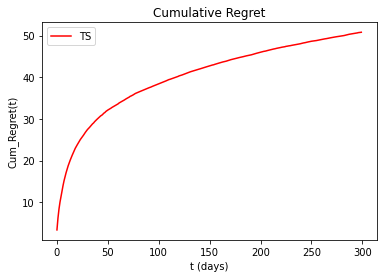

In [11]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS3 - collected_rewards_TS3, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

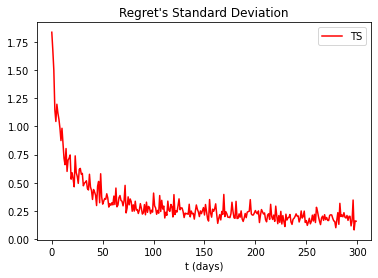

In [12]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS3 - collected_rewards_TS3, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

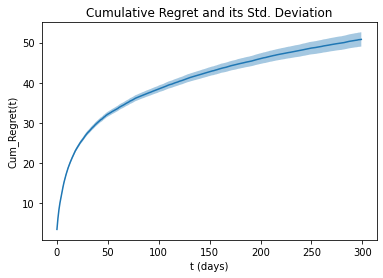

In [13]:
# mean_R = np.mean(R, axis=0)
cum_R_TS3 = np.cumsum(opt_reward_TS3 - collected_rewards_TS3, axis = 1)
mean_cum_R_TS3 = np.mean(cum_R_TS3, axis = 0)
std_dev_TS3 = np.std(cum_R_TS3, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS3)
plt.fill_between(range(n_days), mean_cum_R_TS3-std_dev_TS3, mean_cum_R_TS3+std_dev_TS3, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

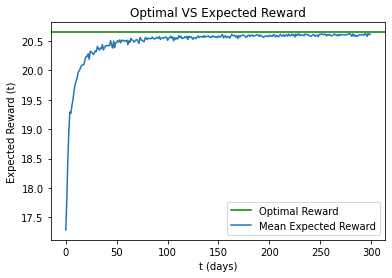

In [14]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS3, color = 'green')
plt.plot(np.mean(collected_rewards_TS3, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

### Explore the istant regret in the collected runs of the step 3 learner

In [ ]:
(opt_reward_TS3 - collected_rewards_TS3)[-2][-20:]

In [ ]:
learner_TS3.price_comb_history[-1][-20:]

- ### Comparison between mean conversion rates estimated by last run of TS and real values

In [ ]:
CR_mean = np.array(learner_TS3.cr_matrix_list).mean(axis = 0)
i = 9
CR_i = learner_TS3.cr_matrix_list[i]
print("Mean of estimated conversion rates \n", CR_mean)

print("\nEstimated conversion rates for run %d \n" %i, CR_i)

In [ ]:
np.matrix(env.theoretical_values['conversion_rates'][0])

In [ ]:
# CODICE PER TESTARE SE UN PREZZO PER UN DETERMINATO PRODOTTO E' STATO "ESPLORATO" DALL'ALGORITMO
comb_list = learner_TS3.price_comb_history[-1]
count = 0
prod = 0
price = 0

for comb in comb_list :
    count += 1 if comb[prod] == price else 0

count

## - UCB1

In [89]:
# setting the run parameters
n_runs = 3
daily_users = 200
n_days = 300

In [90]:
opt_reward = env.optimal_reward()[0]
ucb3 = step3_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb3.run(n_days, daily_users)

In [91]:
# store the result
with open("ucb3", 'wb') as f1:
    pickle.dump(ucb3, f1)

In [92]:
# load the result
with open("ucb3", 'rb') as f1:
    ucb3 = pickle.load(f1)

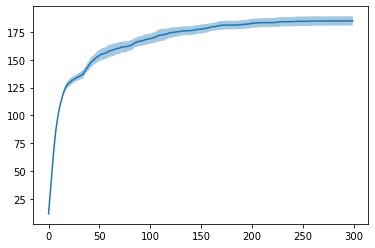

In [93]:
step3_ucb1_collected_rewards = ucb3.collected_rewards
step3_ucb1_R = ucb3.regret
# plot of the result
mean_step3_ucb1_R = np.mean(step3_ucb1_R, axis=0)
std_dev_step3_ucb1 = np.std(step3_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step3_ucb1_R)
plt.fill_between(range(n_days), mean_step3_ucb1_R-std_dev_step3_ucb1, mean_step3_ucb1_R+std_dev_step3_ucb1, alpha=0.4)

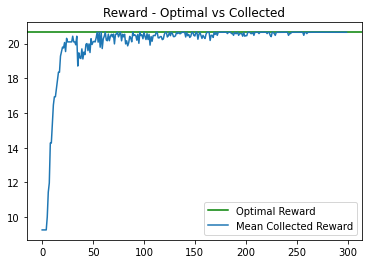

In [94]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step3_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [95]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb3.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

Last n pulled arms:


[[0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0]]

In [96]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb3.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

C:\Users\stefa\AppData\Local\Temp/ipykernel_11516/635266706.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result.append(x[np.argmax(np.array(x)[:, 1])])
C:\Users\stefa\AppData\Local\Temp/ipykernel_11516/635266706.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
C:\Users\stefa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

Optimal arms combination:
[0, 1, 2, 1, 0] 20.651157065146457


Ucb1 most pulled arms:
(arms combination), (n° pulls), (exp rew)


[[[0, 1, 2, 1, 0], 113, 20.651157065146457],
 [[0, 1, 2, 0, 0], 80, 20.645580219306414],
 [[1, 1, 2, 0, 0], 19, 20.422663368535716],
 [[1, 1, 1, 1, 0], 14, 20.121290049315945],
 [[1, 1, 2, 1, 0], 11, 20.423557603243626],
 [[3, 3, 3, 3, 3], 6, 9.268398595840193],
 [[0, 1, 1, 1, 0], 5, 20.328276656643165],
 [[1, 1, 3, 1, 0], 5, 19.438482687494467],
 [[2, 2, 2, 2, 1], 5, 16.459104409832374],
 [[1, 1, 1, 2, 0], 4, 19.32659484455472],
 [[0, 1, 3, 0, 0], 3, 19.630042194936703],
 [[1, 1, 1, 1, 1], 3, 18.642955872309194],
 [[1, 2, 1, 1, 0], 3, 19.75699208062557],
 [[1, 2, 2, 2, 0], 3, 19.2776127140582],
 [[2, 2, 3, 2, 2], 3, 14.890239708456626],
 [[0, 1, 1, 2, 0], 2, 19.53003262808147],
 [[0, 1, 2, 2, 0], 2, 19.857444463289553],
 [[0, 1, 3, 1, 0], 2, 19.655233906430162],
 [[0, 2, 1, 1, 0], 2, 19.973977869290117],
 [[0, 2, 2, 0, 0], 2, 20.285754860939285]]

In [97]:
ucb3.print_estimations()

Conversion rates - estimated means:
 [[0.87241355 0.68310671 0.4507772  0.22965116]
 [0.         0.8007064  0.61706667 0.37715517]
 [0.         0.8120743  0.64271654 0.45892857]
 [0.92593154 0.74062469 0.61204268 0.31784841]
 [0.64429882 0.40786749 0.24657534 0.09926471]]

Conversion rates - estimated widths:
 [[0.87241355 0.68310671 0.4507772  0.22965116]
 [0.         0.8007064  0.61706667 0.37715517]
 [0.         0.8120743  0.64271654 0.45892857]
 [0.92593154 0.74062469 0.61204268 0.31784841]
 [0.64429882 0.40786749 0.24657534 0.09926471]]


# STEP 4 : Uncertain conversion rates, alpha ratio and number of products sold

## - TS

In [15]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta_CR = [a, b]
initial_beta_alpha = np.ones((2,5))
initial_n_prod_data = np.ones((2,5))
learner_TS4 = Step4_TS(env, initial_beta_CR, initial_beta_alpha, initial_n_prod_data, learning_rate=1.0)

In [16]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner_TS4.reward_history = []
learner_TS4.price_comb_history = []
learner_TS4.cr_matrix_list = []
learner_TS4.alpha_ratios_list = []
learner_TS4.n_prod_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS4.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS4 = learner_TS4.opt_reward
collected_rewards_TS4 = learner_TS4.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [17]:
with open('step4_TS_rewards', 'wb') as f: 
    pickle.dump(collected_rewards_TS4, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step4_TS_rewards', 'rb') as f: 
    collected_rewards_TS4 = pickle.load(f)

- ### Cumulative Regret Plot

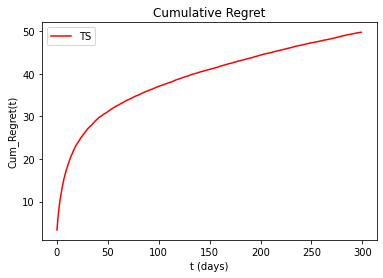

In [18]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS4 - collected_rewards_TS4, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

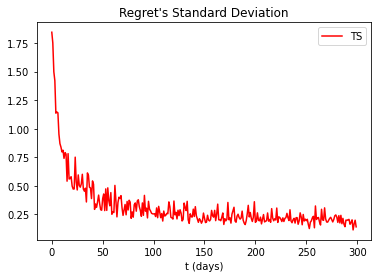

In [19]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS4 - collected_rewards_TS4, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

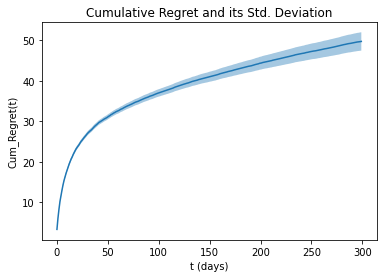

In [20]:
# mean_R = np.mean(R, axis=0)
cum_R_TS4 = np.cumsum(opt_reward_TS4 - collected_rewards_TS4, axis = 1)
mean_cum_R_TS4 = np.mean(cum_R_TS4, axis = 0)
std_dev_TS4 = np.std(cum_R_TS4, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS4)
plt.fill_between(range(n_days), mean_cum_R_TS4-std_dev_TS4, mean_cum_R_TS4+std_dev_TS4, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

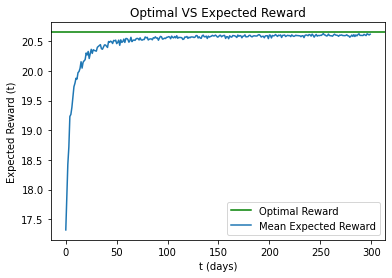

In [21]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS4, color = 'green')
plt.plot(np.mean(collected_rewards_TS4, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## - UCB1

In [98]:
# setting the run parameters
n_runs = 3
daily_users = 200
n_days = 300

In [99]:
opt_reward = env.optimal_reward()[0]
ucb4 = step4_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb4.run(n_days, daily_users)

In [100]:
# store the result
with open("ucb4", 'wb') as f1:
    pickle.dump(ucb4, f1)

In [101]:
# load the result
with open("ucb4", 'rb') as f1:
    ucb4 = pickle.load(f1)

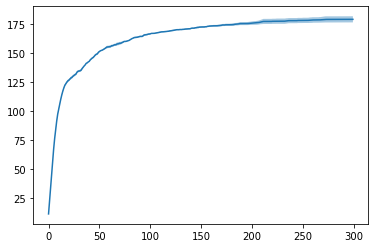

In [102]:
step4_ucb1_collected_rewards = ucb4.collected_rewards
step4_ucb1_R = ucb4.regret
# plot of the result
mean_step4_ucb1_R = np.mean(step4_ucb1_R, axis=0)
std_dev_step4_ucb1 = np.std(step4_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step4_ucb1_R)
plt.fill_between(range(n_days), mean_step4_ucb1_R-std_dev_step4_ucb1, mean_step4_ucb1_R+std_dev_step4_ucb1, alpha=0.4)

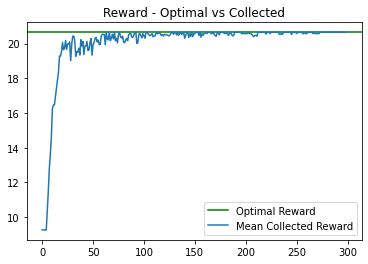

In [103]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step4_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [104]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb4.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

Last n pulled arms:


[[0, 1, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 1, 0]]

In [105]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb4.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

C:\Users\stefa\AppData\Local\Temp/ipykernel_11516/1187494405.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result.append(x[np.argmax(np.array(x)[:, 1])])
C:\Users\stefa\AppData\Local\Temp/ipykernel_11516/1187494405.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
C:\Users\stefa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

Optimal arms combination:
[0, 1, 2, 1, 0] 20.651157065146457


Ucb1 most pulled arms:
(arms combination), (n° pulls), (exp rew)


[[[0, 1, 2, 0, 0], 113, 20.645580219306414],
 [[0, 1, 2, 1, 0], 69, 20.651157065146457],
 [[0, 2, 2, 0, 0], 24, 20.285754860939285],
 [[1, 1, 2, 0, 0], 20, 20.422663368535716],
 [[0, 2, 2, 1, 0], 8, 20.29324032804404],
 [[1, 1, 1, 1, 0], 8, 20.121290049315945],
 [[1, 1, 2, 1, 0], 7, 20.423557603243626],
 [[1, 2, 2, 1, 0], 6, 20.058728768459847],
 [[0, 2, 1, 1, 0], 5, 19.973977869290117],
 [[3, 3, 3, 3, 3], 5, 9.268398595840193],
 [[0, 1, 3, 1, 0], 4, 19.655233906430162],
 [[1, 2, 2, 2, 0], 4, 19.2776127140582],
 [[0, 1, 1, 1, 0], 3, 20.328276656643165],
 [[1, 2, 2, 2, 1], 3, 17.885075308042584],
 [[0, 2, 1, 2, 0], 2, 19.188174959773427],
 [[1, 1, 1, 2, 0], 2, 19.32659484455472],
 [[1, 1, 3, 1, 0], 2, 19.438482687494467],
 [[2, 2, 2, 2, 1], 2, 16.459104409832374],
 [[2, 3, 3, 3, 2], 2, 11.968286714696836],
 [[0, 1, 2, 1, 1], 1, 19.16699446458953]]

In [107]:
ucb4.print_estimations()

Estimated alpha ratios:
 [0.20368313 0.19772848 0.19744822 0.2008314  0.20030876]

Estimated n of products sold:

 [0.20368313 0.19772848 0.19744822 0.2008314  0.20030876]
Conversion rates - estimated means:
 [[0.87266067 0.6765108  0.375      0.2012987 ]
 [0.         0.79900492 0.64476732 0.40078585]
 [0.         0.79393939 0.6479276  0.46193548]
 [0.92871346 0.73227917 0.58511723 0.33254717]
 [0.64884476 0.37317073 0.25084746 0.08695652]]

Conversion rates - estimated widths:
 [[0.87266067 0.6765108  0.375      0.2012987 ]
 [0.         0.79900492 0.64476732 0.40078585]
 [0.         0.79393939 0.6479276  0.46193548]
 [0.92871346 0.73227917 0.58511723 0.33254717]
 [0.64884476 0.37317073 0.25084746 0.08695652]]


# STEP 5 : Uncertain conversion rates and graph weights

## - TS

In [22]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a_cr = np.ones((5,4))
b_cr = np.ones((5,4))
initial_beta_CR = [a_cr, b_cr]
a_gw = np.ones((5,2))
b_gw = np.ones((5,2))
initial_beta_gw = [a_gw, b_gw]
learner_TS5 = Step5_TS(env, initial_beta_CR, initial_beta_gw, learning_rate=1.0)

In [23]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner_TS5.reward_history = []
learner_TS5.price_comb_history = []
learner_TS5.cr_matrix_list = []
learner_TS5.graph_weights_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS5.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS5 = learner_TS5.opt_reward
collected_rewards_TS5 = learner_TS5.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [24]:
with open('step5_TS_rewards', 'wb') as f: 
    pickle.dump(collected_rewards_TS5, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step5_TS_rewards', 'rb') as f: 
    collected_rewards_TS5 = pickle.load(f)

- ### Cumulative Regret Plot

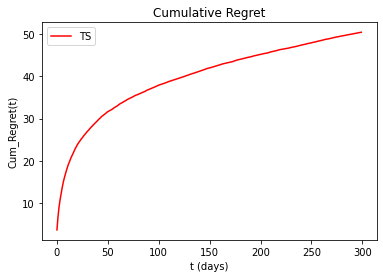

In [25]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS5 - collected_rewards_TS5, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

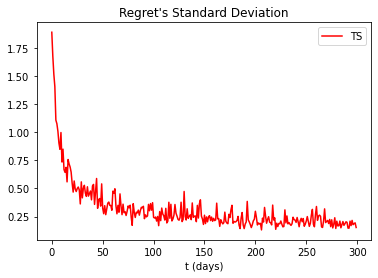

In [26]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS5 - collected_rewards_TS5, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

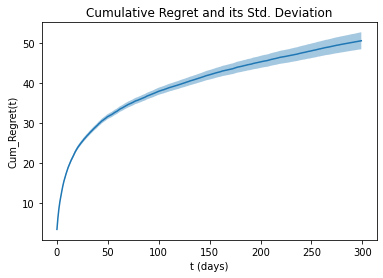

In [27]:
# mean_R = np.mean(R, axis=0)
cum_R_TS5 = np.cumsum(opt_reward_TS5 - collected_rewards_TS5, axis = 1)
mean_cum_R_TS5 = np.mean(cum_R_TS5, axis = 0)
std_dev_TS5 = np.std(cum_R_TS5, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS5)
plt.fill_between(range(n_days), mean_cum_R_TS5-std_dev_TS5, mean_cum_R_TS5+std_dev_TS5, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

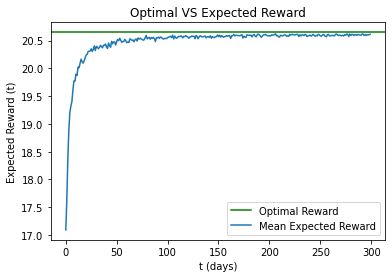

In [28]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS5, color = 'green')
plt.plot(np.mean(collected_rewards_TS5, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## - UCB1

In [108]:
# setting the run parameters
n_runs = 3
daily_users = 200
n_days = 300

In [109]:
opt_reward = env.optimal_reward()[0]
ucb5 = step5_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb5.run(n_days, daily_users)

In [110]:
# store the result
with open("ucb5", 'wb') as f1:
    pickle.dump(ucb5, f1)

In [111]:
# load the result
with open("ucb5", 'rb') as f1:
    ucb5 = pickle.load(f1)

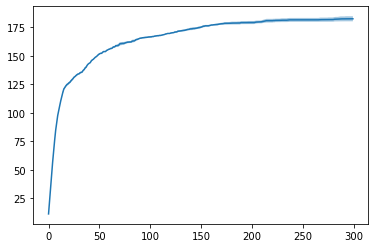

In [112]:
step5_ucb1_collected_rewards = ucb5.collected_rewards
step5_ucb1_R = ucb5.regret
# plot of the result
mean_step5_ucb1_R = np.mean(step5_ucb1_R, axis=0)
std_dev_step5_ucb1 = np.std(step5_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step5_ucb1_R)
plt.fill_between(range(n_days), mean_step5_ucb1_R-std_dev_step5_ucb1, mean_step5_ucb1_R+std_dev_step5_ucb1, alpha=0.4)
plt.show()

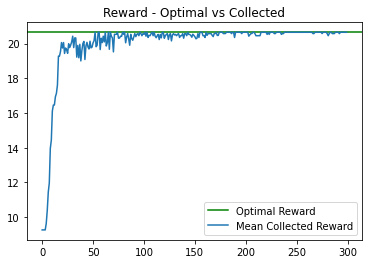

In [113]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step5_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [114]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb5.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

Last n pulled arms:


[[0, 1, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0]]

In [115]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb5.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

C:\Users\stefa\AppData\Local\Temp/ipykernel_11516/1309711750.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result.append(x[np.argmax(np.array(x)[:, 1])])
C:\Users\stefa\AppData\Local\Temp/ipykernel_11516/1309711750.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
C:\Users\stefa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

Optimal arms combination:
[0, 1, 2, 1, 0] 20.651157065146457


Ucb1 most pulled arms:
(arms combination), (n° pulls), (exp rew)


[[[0, 1, 2, 0, 0], 102, 20.645580219306414],
 [[0, 1, 2, 1, 0], 98, 20.651157065146457],
 [[1, 1, 1, 1, 0], 10, 20.121290049315945],
 [[0, 2, 1, 1, 0], 9, 19.973977869290117],
 [[0, 2, 2, 0, 0], 8, 20.285754860939285],
 [[1, 1, 2, 0, 0], 8, 20.422663368535716],
 [[0, 1, 1, 1, 0], 7, 20.328276656643165],
 [[0, 2, 2, 1, 0], 5, 20.29324032804404],
 [[1, 1, 2, 1, 0], 5, 20.423557603243626],
 [[3, 3, 3, 3, 3], 5, 9.268398595840193],
 [[1, 2, 2, 1, 0], 4, 20.058728768459847],
 [[0, 1, 1, 2, 0], 3, 19.53003262808147],
 [[1, 1, 1, 0, 0], 3, 20.067871467732616],
 [[1, 1, 3, 1, 0], 3, 19.438482687494467],
 [[1, 2, 2, 2, 0], 3, 19.2776127140582],
 [[2, 2, 2, 2, 1], 3, 16.459104409832374],
 [[0, 1, 2, 2, 0], 2, 19.857444463289553],
 [[0, 1, 3, 1, 0], 2, 19.655233906430162],
 [[0, 2, 1, 0, 0], 2, 19.9123049379563],
 [[1, 1, 1, 2, 0], 2, 19.32659484455472]]

In [116]:
ucb5.print_estimations()

Estimated graph weights (lambda included):

 [[0.         0.60375287 0.14029064 0.         0.        ]
 [0.49557583 0.         0.28334075 0.         0.        ]
 [0.         0.49691292 0.         0.35497703 0.        ]
 [0.         0.         0.59586168 0.         0.34940718]
 [0.         0.         0.29904045 0.34427889 0.        ]]

Conversion rates - estimated means:
 [[0.87591427 0.67511281 0.44087838 0.19655172]
 [0.         0.80689917 0.64154412 0.45979899]
 [0.         0.81144578 0.64100346 0.44548063]
 [0.9241975  0.73753448 0.58669002 0.33488372]
 [0.63842244 0.3373494  0.27169811 0.07211538]]

Conversion rates - estimated widths:
 [[0.87591427 0.67511281 0.44087838 0.19655172]
 [0.         0.80689917 0.64154412 0.45979899]
 [0.         0.81144578 0.64100346 0.44548063]
 [0.9241975  0.73753448 0.58669002 0.33488372]
 [0.63842244 0.3373494  0.27169811 0.07211538]]


# STEP 6 : Abrupt Changes in Demand Curve with Uncertain Conversion Rates and Graph Weights

In [57]:
from step6_sw_ucb import *

In [58]:
#########################
# ABRUPT CHANGE SETTING #
#########################
changes_dict ={
    0 : {"mean": [9.7, 12.7, 24.5, 31.6, 41.1],"std": [1.5, 2, 4, 2.5, 3]},
    75 : {"mean": [9.0, 11.3, 23.2, 30.1, 39.7], "std": [1.3, 1.7, 3.5, 2.1, 2.7]},
    150 : {"mean": [10.5, 14.0, 25.8, 32.0, 43.0], "std": [1.7, 2.2, 4.3, 2.9, 3.2]},
    225 : {"mean": [9.7, 12.7, 24.5, 31.6, 41.1], "std": [1.5, 2, 4, 2.5, 3]}
}
opt_reward = env.optimal_reward()[0]
opt_reward_evolution = np.zeros(n_days)
original_res_price_param = copy.deepcopy(env.users[0].res_price_params)
for t in range(n_days):
    if t in changes_dict.keys(): 
        env.abrupt_change_deterministic([changes_dict[t]])
        opt_reward = env.optimal_reward()[0]
    opt_reward_evolution[t] = opt_reward

env.abrupt_change_deterministic([original_res_price_param])

- ### sw_ucb

In [ ]:
n_runs = 3
daily_users = 200
n_days = 300

In [59]:
sw = 75
sw_ucb = step6_sw_ucb(len(prices), len(prices[0]), prices, env, changes_dict, sw)
for _ in range(n_runs):
    sw_ucb.run(n_days, daily_users)

In [60]:
# store the result
with open("sw_ucb", 'wb') as f1:
    pickle.dump(sw_ucb, f1)

In [61]:
# load the result
with open("sw_ucb", 'rb') as f1:
    sw_ucb = pickle.load(f1)

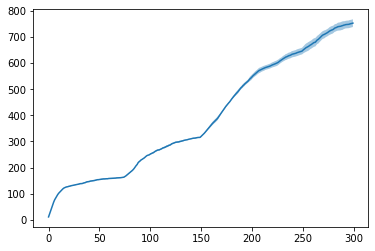

In [62]:
sw_ucb_collected_rewards = sw_ucb.collected_rewards
sw_ucb_R = sw_ucb.regret
# plot of the result
mean_sw_ucb_R = np.mean(sw_ucb_R, axis=0)
std_sw_ucb = np.std(sw_ucb_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_sw_ucb_R)
plt.fill_between(range(n_days), mean_sw_ucb_R-std_sw_ucb, mean_sw_ucb_R+std_sw_ucb, alpha=0.4)
plt.show()

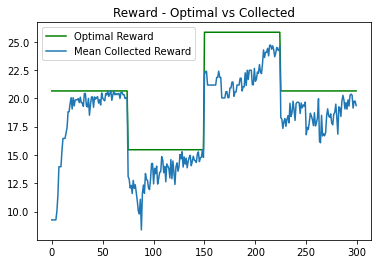

In [68]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.plot(opt_reward_evolution, color = 'green')
plt.plot(np.mean(sw_ucb_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

- ### simple ucb on abrupt changes

In [ ]:
n_runs = 3
daily_users = 200
n_days = 300

In [64]:
sw = np.inf
simple_ucb = step6_sw_ucb(len(prices), len(prices[0]), prices, env, changes_dict, sw)
for _ in range(n_runs):
    simple_ucb.run(n_days, daily_users)

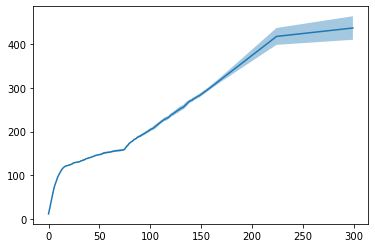

In [65]:
simple_collected_rewards = simple_ucb.collected_rewards
simple_R = simple_ucb.regret
# plot of the result
mean_simple_R = np.mean(simple_R, axis=0)
std_simple = np.std(simple_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_simple_R)
plt.fill_between(range(n_days), mean_simple_R-std_simple, mean_simple_R+std_simple, alpha=0.4)
plt.show()

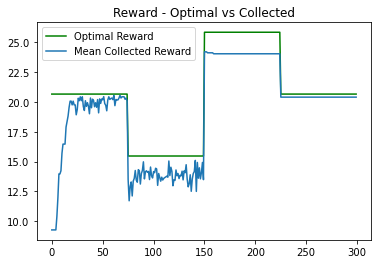

In [66]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.plot(opt_reward_evolution, color = 'green')
plt.plot(np.mean(simple_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"], loc = 'lower right')
plt.show()

# STEP 7 : Context generation algorithms

In [ ]:
# step 7 --> daily users
feature_list = [[[0,1]], [[0,0],[1,0]], [[1,1]]]
learner_list = []
sampled_value_list = []
simul_info ->dict{'00' : dict( CR_matrix qui! )} # informazioni delle simulazioni dal giorno 0 al giorno t

# sample per ogni learner delle quantità incerte
for learner in learner_list :
    sampled_value_list[i]['CR'] =learner.sample_CR
    ..

# greedy optimizer per ogni context generato
for learner in learner_list :
    opt_price_comb[i] = greedy_optimizer(...)

# simulazione della giornata
daily_informations = simulate_day(daily_users, opr_price_comb_list, uncertain_list, context = feature_list)
->dict{'00' : dict(output simulate_day classico + count delle volte che la coppia di feature è uscita)}

# ! aggiornamento informazioni simulazione
simul_info.update(daily_informations, opt_price_comb_list) # update NON E' un append ma sommi i valori corrispondenti

# aggiornamento dei parametri:
for learner in learner_list :
    ... # rielaborazione di daily_information basa su feature_list (quindi aggreghi per context; aggregare = somma)
    learner.update_parameters(opt_price_combI, ...)

###### CONTEXT GENERATION ######
... > output: feature_list ...
# --> ridefinire learner_list in base al nuovo feature_list
# i parametri per beta o medie li prendiamo da simul info --> per le beta possiamo definire un "variability_rate" tra 0 e 1 
# per rimpicciolire i valori da mettere per A e B della beta (A e B matrici 5x4)


In [ ]:
simul_dict = {'00':{'alpha', 'CR', 'prod'}}
expected_reward(price_comb, uncertain, feature_list = [[0,1], [0,0]])

In [ ]:
learner.beta_parameters

In [ ]:
# parser matrice --> feature_list
n_groups = np.max(matrix)+1
feature_list = []
for i in len(n_groups):
    ind_list = return_indices(matrix, i)
    feature_list.append(list(feature_list))
